# 0-) IMPORTS

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import tensorflow        as tf

from tensorflow.keras import layers, models
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers             import Adam

# 1-) DATA ANALYSIS

In [3]:
max_features = 10000 #Most used 10000 words.
maxlen       = 100   #Max word of comments.

In [4]:
(X_train,y_train),(X_test,y_test) = imdb.load_data(num_words=max_features)

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

(25000,)
(25000,)
(25000,)
(25000,)
25000
25000
25000
25000


In [6]:
# Set max len to 100 words
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test  = pad_sequences(X_test , maxlen=maxlen)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

(25000, 100)
(25000,)
(25000, 100)
(25000,)
25000
25000
25000
25000


In [8]:
word_index = imdb.get_word_index()

In [9]:
reverse_word_index = {index+3: word for word, index in word_index.items()}

In [10]:
reverse_word_index[0] = "<PAD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNKNOWN>"
reverse_word_index[3] = "<UNUSED>"

In [11]:
#write examples
def decode_review(encoded_review):
    return " ".join([reverse_word_index.get(i,"?") for i in encoded_review])

In [12]:
random_indices = np.random.choice(len(X_train), size=5, replace=False)
for i in random_indices:
    print(f"Comment: {decode_review(X_train[i])}")
    print(f"Label  : {y_train[i]}")
    print()

Comment: what i understand the film has been altered behind his back to the current state it's in seagal will apparently not be working with these people again or with <UNKNOWN> <UNKNOWN> who continue to deliver <UNKNOWN> sub <UNKNOWN> image that's saying something material br br overall this is one to avoid if you are not a seagal fan seagal fans can also be safe in the knowledge that the big man probably won't want to do anything this bad again unfortunately his next film which has already been shot with the same people promises to be even worse than this
Label  : 0

Comment: itchy and a little girl called anne marie who comes slightly later two i love the period of history in which this film is set it is set during the <UNKNOWN> in the united states three the don <UNKNOWN> animation as usual is superb the backgrounds are good too four there is a strange excitement in this film that keeps me on the edge of my seat five the songs in this are lovely my favourite song starts with i need

# 2-) MODELLING

## A-) Transformer Layer

In [13]:
class TransformerBlock(layers.Layer):
    # Create Transformer layer
    # Connects self-attention network with feed forward network.
    
    # embed_size: embedding vector size from input
    # heads: number of header that will be used in multi head attention mechanism
    def __init__(self, embed_size, heads, dropout_rate = 0.3):
        super(TransformerBlock, self).__init__() #Inherit features of layer.layer superclass by calling __init__() method.
        
        #Attention mechanism
        self.attention = layers.MultiHeadAttention(num_heads = heads,     #Number of attention calculation at once
                                                   key_dim   = embed_size)#Key size that will be used for every attention header
        #Normalization
        self.norm1  = layers.LayerNormalization(epsilon = 1e-6) #Epsilon: used for numerical stability
        self.norm2  = layers.LayerNormalization(epsilon = 1e-6) #Epsilon: used for numerical stability
        
        #FEED FORWARD
        self.feed_forward = models.Sequential([layers.Dense(embed_size*heads, activation='relu'), # Multiply embed_size by heads
                                               layers.Dense(embed_size)                           # Turn embed_size to original   
        ])
        
        #Dropout
        self.dropout1     = layers.Dropout(dropout_rate)
        self.dropout2     = layers.Dropout(dropout_rate)

    #call    :define how input is processed
    #x       :input vector
    #training:Dropout yes/no
    def call(self, x, training):
        #self attention mechanism, learn relationship between every word
        attention = self.attention(x,x)
        
        #Residual block (skip connection)
        #Sumup attention output with original input
        x = self.norm1(x+self.dropout1(attention, training=training))
        
        #Feed forward network
        feed_forward = self.feed_forward(x)
        #Residual block
        return self.norm2(x+self.dropout2(feed_forward, training=training))

## B-) Create Transformer Model

In [14]:
# Model class that uses transformer architecture

#Inputs-->transformer blocks-->classify output
class TransformerModel(models.Model):
    
    #num_layers: Transofrmer layer count
    # embed_size: embedding vector size from input
    # heads: number of header that will be used 
    #        in multi head attention mechanism for every transformer block
    # input_dim: number of possible token(words) in the entry.
    # output_size: class size of output
    def __init__(self, num_layers, embed_size,heads,input_dim,output_dim,dropout_rate=0.1):
        super(TransformerModel, self).__init__() #Inherit features of models.Model superclass by calling __init__() method.

        #transform inputs(words,symbols) to number vectors
        self.embedding = layers.Embedding(input_dim=input_dim,
                                          output_dim=embed_size)
        #Loop for creating multiple transformer layers.
        #num_layers: Number of transformer layers.
        self.transformer_blocks = [TransformerBlock(embed_size=embed_size,
                                                    heads=heads,
                                                    dropout_rate=dropout_rate) for _ in range(num_layers)]
        #Pooling layer
        self.global_avg_pooling = layers.GlobalAveragePooling1D()
        
        self.dropout = layers.Dropout(dropout_rate)

        #Fully connected layer
        self.fc = layers.Dense(output_dim, activation="sigmoid")
    
    #call    :define how input is processed
    #x       :input vector
    #training:Dropout yes/no
    def call(self,x,training):
        #The token array is passed through the embedded layer.
        #As a result, tokens are converted into fixed-size vectors.
        x = self.embedding(x)
        
        #Run every transformer block
        for transformer in self.transformer_blocks:
            x = transformer(x, training=training)
        
        #Pooling Layer
        x = self.global_avg_pooling(x)

        x = self.dropout(x, training=training)
        #By passing it to FC the output is calculated.
        return self.fc(x)

## C-) Model Training

In [15]:
# Hyper parameters
num_layers   = 4 #number of transformer layers
embed_size   = 64
num_head     = 4 #Number of multi-head(attention head)
input_dim    = max_features
output_dim   = 1 #positive/negative
dropout_rate = 0.1

In [17]:
#Create model
model = TransformerModel(num_layers   = num_layers,
                         embed_size   = embed_size,
                         heads        = num_head,
                         input_dim    = input_dim,
                         output_dim   = output_dim,
                         dropout_rate = dropout_rate)
#Build model
model.build(input_shape = (None, maxlen))
#Compile model
model.compile(optimizer = Adam(learning_rate=1e-4),
              loss      = "binary_crossentropy",
              metrics   = [tf.keras.metrics.Precision(name="precision"),
                           tf.keras.metrics.Recall(name="recall"),
                           tf.keras.metrics.AUC(name="auc"),
                           "accuracy"])
model.summary()


c:\Users\Giray\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:393: UserWarning: `build()` was called on layer 'transformer_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "transformer_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ ?                      │   0 (unbuilt) │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ ?                      │   0 (unbuilt) │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ ?                      │   0 (unbuilt) │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ ?                      │   0 (unbuilt) │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
#Train model
history = model.fit(X_train,y_train, epochs=20, batch_size=512, validation_data=(X_test,y_test))

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.5437 - auc: 0.5574 - loss: 0.7071 - precision: 0.5414 - recall: 0.5383 - val_accuracy: 0.7003 - val_auc: 0.7895 - val_loss: 0.6095 - val_precision: 0.7737 - val_recall: 0.5662
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7278 - auc: 0.8045 - loss: 0.5619 - precision: 0.7348 - recall: 0.7126 - val_accuracy: 0.7986 - val_auc: 0.8875 - val_loss: 0.4332 - val_precision: 0.7640 - val_recall: 0.8643
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8307 - auc: 0.9109 - loss: 0.3793 - precision: 0.8259 - recall: 0.8373 - val_accuracy: 0.8326 - val_auc: 0.9158 - val_loss: 0.3696 - val_precision: 0.8255 - val_recall: 0.8434
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8728 - auc: 0.9451 - loss: 0.3011 - precision: 0.8722 - recall: 0.8749 - val_accuracy: 0.8429 - val_auc: 0.9238 - val_loss: 0.3593 - val_precision: 0.8518 - val_recall: 0.8302
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 88

# 3-) TESTING

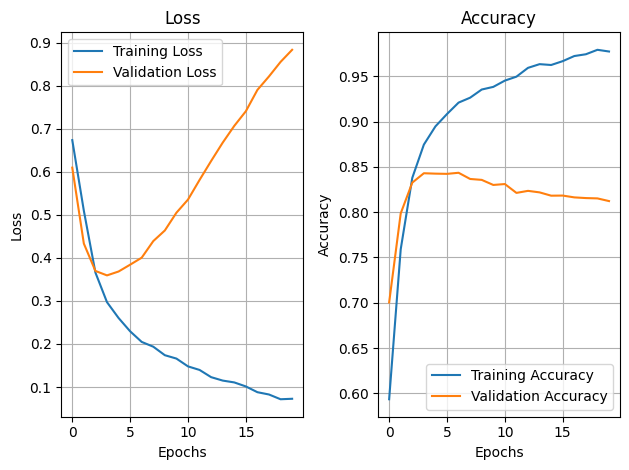

In [22]:
plt.figure()

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
#get user input

def predict_sentiment(model, text, word_index, maxlen):
    #turn text to number
    encoded_text = [word_index.get(word,0) for word in text.lower().split() if word in word_index]
    #padding
    padded_text = pad_sequences([encoded_text], maxlen=maxlen)
    #prediction
    prediction = model.predict((padded_text))

    return prediction[0][0]

In [34]:
word_index = imdb.get_word_index()

user_input = input("Enter a movie review: ")
sentiment_score = predict_sentiment(model, user_input, word_index, maxlen)

if sentiment_score > 0.5:
    print(f"Sentiment Score guessed positive with %{sentiment_score*100} confidence")
else:
    print(f"Sentiment Score guessed negative with %{sentiment_score*100} confidence")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sentiment Score guessed positive with %88.26642036437988 confidence


In [46]:
def control_review(review):
    print(f"\nReview is: {review}")
    sentiment_score = predict_sentiment(model, review, word_index, maxlen)
    
    if sentiment_score > 0.5:
        print(f"Sentiment Score guessed positive with %{sentiment_score*100} confidence")
    else:
        print(f"Sentiment Score guessed negative with %{100-sentiment_score*100} confidence")

In [53]:
good_reviews = [
    "Absolutely stunning visuals and a gripping story from start to finish. A must-watch!",
    "The cast delivered exceptional performances, and the plot twists kept me on the edge of my seat. Highly recommend!",
    "A beautifully crafted film with a powerful message. The director's vision truly shines through.",
    "Heartwarming and thought-provoking. This movie will stay with you long after the credits roll.",
    "A cinematic masterpiece! The soundtrack, cinematography, and storytelling are top-notch.",
    "The film's pacing is perfect, and the dialogue is both witty and meaningful. A true work of art.",
    "A thrilling ride with an unexpected ending. The performances are stellar, and the direction is flawless.",
    "Emotionally charged and brilliantly executed. This film is a testament to the power of storytelling."
]

bad_reviews = [
    "The plot was predictable and the characters were one-dimensional. Not worth the time.",
    "The film dragged on with little to no excitement. I found myself checking the time frequently.",
    "A disappointing mess with incoherent plot points and lackluster performances.",
    "The special effects were laughable, and the dialogue was cringeworthy. A complete letdown.",
    "A forgettable film with no redeeming qualities. The direction was amateurish, and the script was poorly written.",
    "A complete waste of time. The plot was nonsensical, and the acting was atrocious.",
    "An unoriginal and uninspired movie that failed to leave any impression. Avoid at all costs."
]

In [54]:
for review in good_reviews:
    control_review(review)


Review is: Absolutely stunning visuals and a gripping story from start to finish. A must-watch!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Sentiment Score guessed positive with %99.86472129821777 confidence

Review is: The cast delivered exceptional performances, and the plot twists kept me on the edge of my seat. Highly recommend!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Sentiment Score guessed positive with %97.10386395454407 confidence

Review is: A beautifully crafted film with a powerful message. The director's vision truly shines through.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sentiment Score guessed negative with %98.78332922235131 confidence

Review is: Heartwarming and thought-provoking. This movie will stay with you long after the credits roll.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Sentiment Score guessed positive with %70.12287378311157 confidence

Review is: A cinematic masterpiece! The soundtrack, cinematography, and storytelling are top-notch.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/ste

In [55]:
for review in bad_reviews:
    control_review(review)


Review is: The plot was predictable and the characters were one-dimensional. Not worth the time.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sentiment Score guessed positive with %99.89156723022461 confidence

Review is: The film dragged on with little to no excitement. I found myself checking the time frequently.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Sentiment Score guessed negative with %97.5013205781579 confidence

Review is: A disappointing mess with incoherent plot points and lackluster performances.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Sentiment Score guessed negative with %85.63273251056671 confidence

Review is: The special effects were laughable, and the dialogue was cringeworthy. A complete letdown.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Sentiment Score guessed positive with %76.14840269088745 confidence

Review is: A forgettable film with no redeeming qualities. The direction was amateurish, and the script was poorly written.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sentiment Score 